In [32]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.dpi"] = 300
# mpl.use("agg")
# %matplotlib ipympl
%matplotlib inline

import warnings

warnings.filterwarnings("ignore")

In [33]:
def make_symbol(symbol_period, sampling_freq, c_subs, s_subs, n_subs, qam_vals):
    N = int(sampling_freq * symbol_period)
    # Create the time vector for one OFDM symbol
    t = np.arange(0, symbol_period, 1/sampling_freq)

    # Create the frequency vector for one OFDM symbol
    # The mod_freq*symbol_period MUST be an integer, so the period always ends at the same place (in time).
    mod_freq = np.linspace(
        c_subs - s_subs * n_subs / 2 + s_subs,
        c_subs + s_subs * n_subs / 2,
        n_subs,
    )

    # Generate some example data to modulate onto the subcarriers (complex symbols)
    mod_vals = qam_vals[np.random.randint(0, qam_vals.shape[0], n_subs)]
    # Setting the null subcarriers
    mod_vals[:7] = 0
    mod_vals[int(n_subs / 2) - 1] = 0
    mod_vals[-7:] = 0

    # Adding a) gaussian and b) shift noise to the signal
    v_g = 0.05
    v_p = 0.01
    noise_g = (
        v_g * (np.random.randn(n_subs) + 1j * np.random.randn(n_subs)) / np.sqrt(2)
    )
    noise_p = np.exp(2j * np.pi * v_p * np.random.randn(n_subs))
    mod_vals_noisy = (mod_vals + noise_g) * noise_p

    # Create the OFDM symbol by modulating data onto subcarriers
    data_signal = mod_vals_noisy * np.exp(1j * 2 * np.pi * mod_freq * np.transpose([t]))
    # Summing the signals of different frequency together to form a single waveform (like IFFT)
    signal = np.nansum(data_signal, axis=1)
    # Taking real component of the signal
    signal = np.real(signal)

    #############################
    #  SIGNAL TRAVELS IN-AIR
    #############################

    # DEMODULATING SIGNAL
    demod_freq = np.fft.rfftfreq(N, 1 / sampling_freq)
    demod_vals = np.fft.rfft(signal) * 2 / N

    # Filtering signal with simple "low-pass"?? filter
    for i, f in enumerate(demod_freq):
        if np.abs(demod_vals[i]) < 0.1:
            demod_vals[i] = 0
    # Filtering frequencies for only those in the chosen frequency band
    my_filter = np.logical_and(
        demod_freq >= np.min(mod_freq), demod_freq <= np.max(mod_freq)
    )
    demod_freq = demod_freq[my_filter]
    demod_vals = demod_vals[my_filter]
    return (signal, t), (mod_vals, mod_freq), (demod_vals, demod_freq)


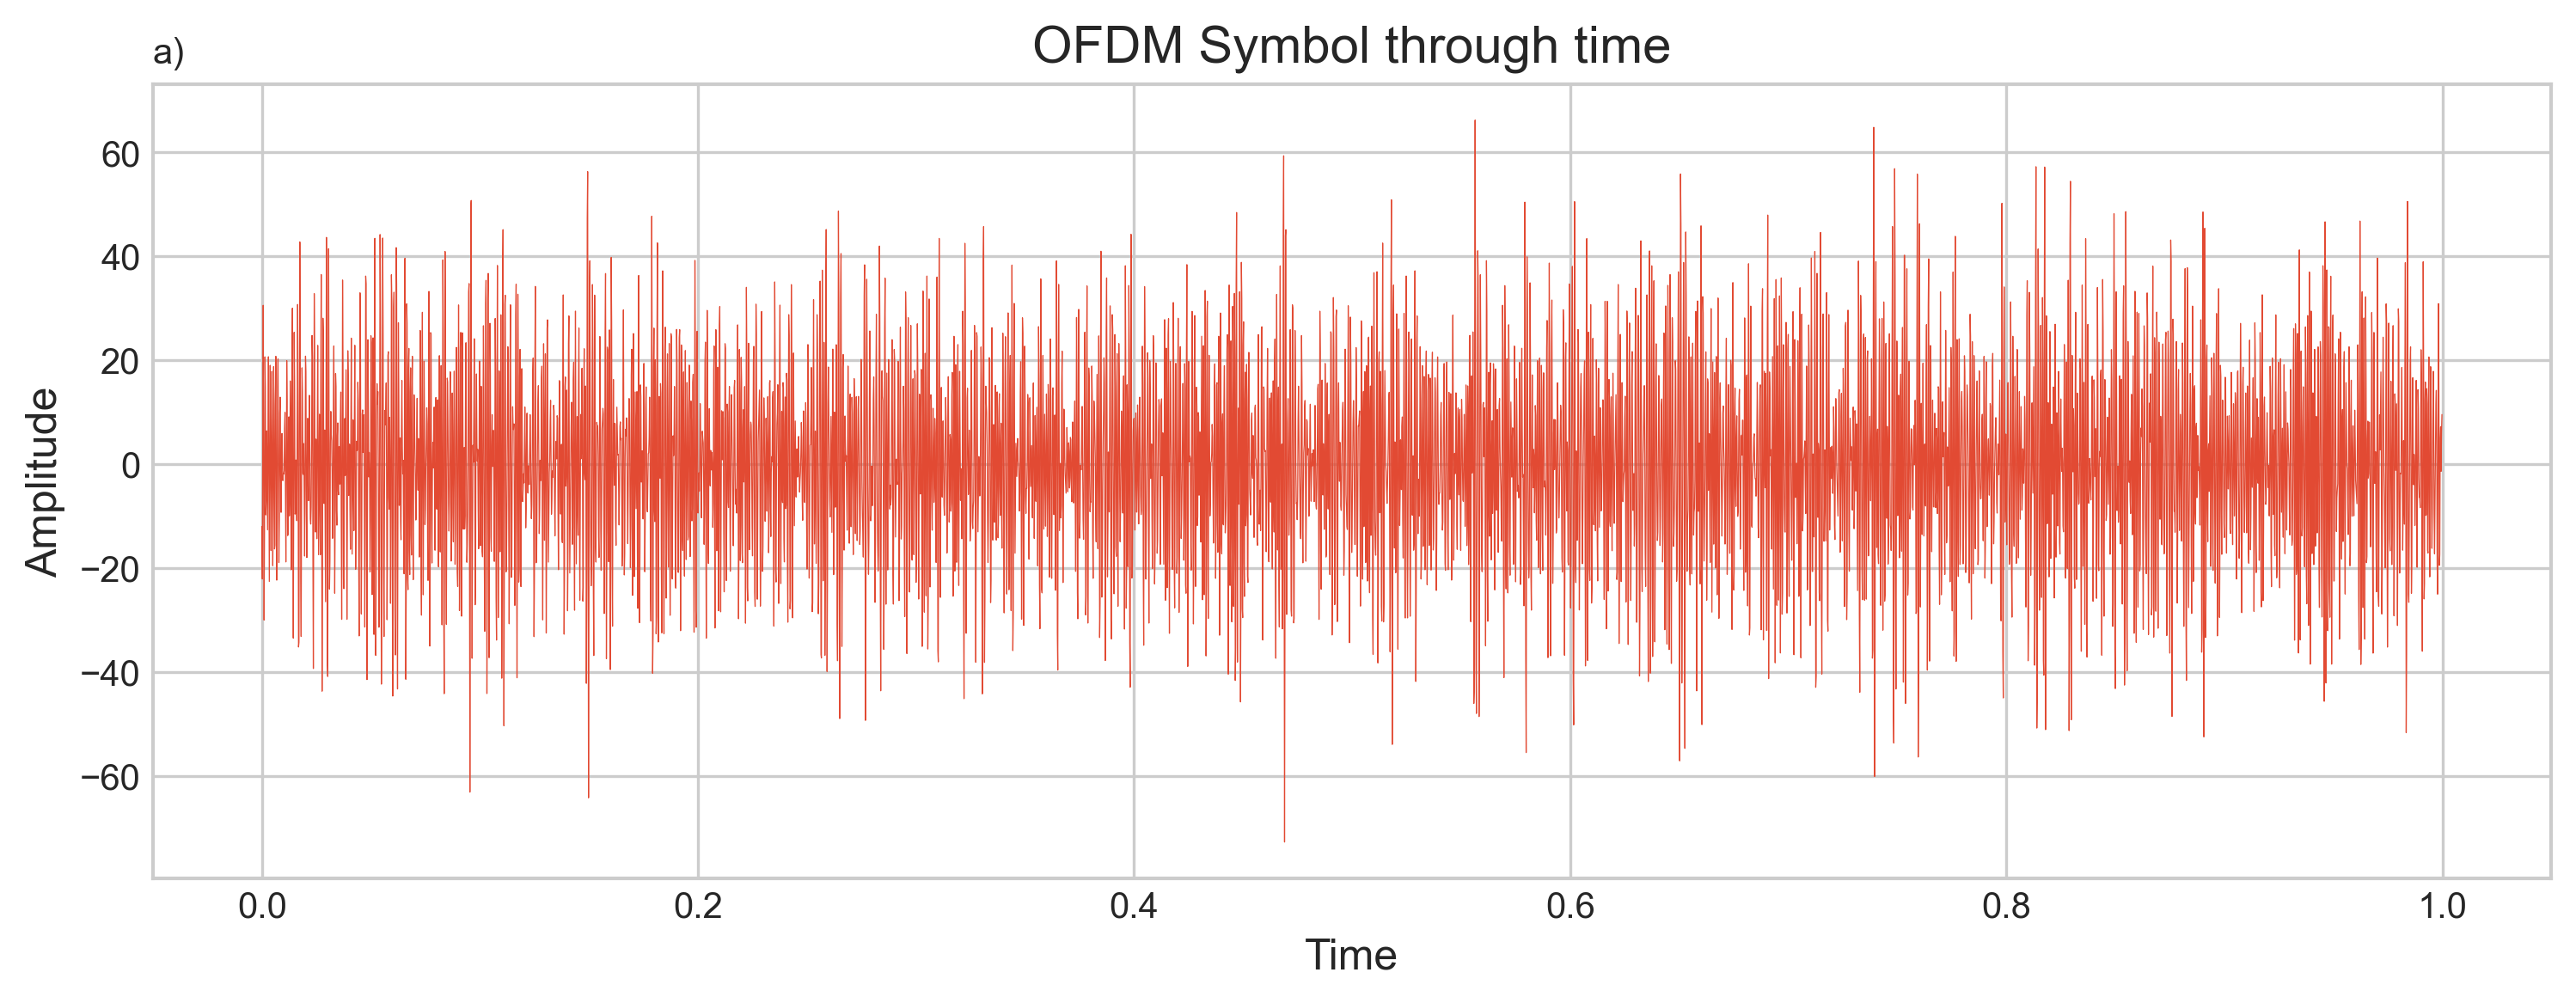

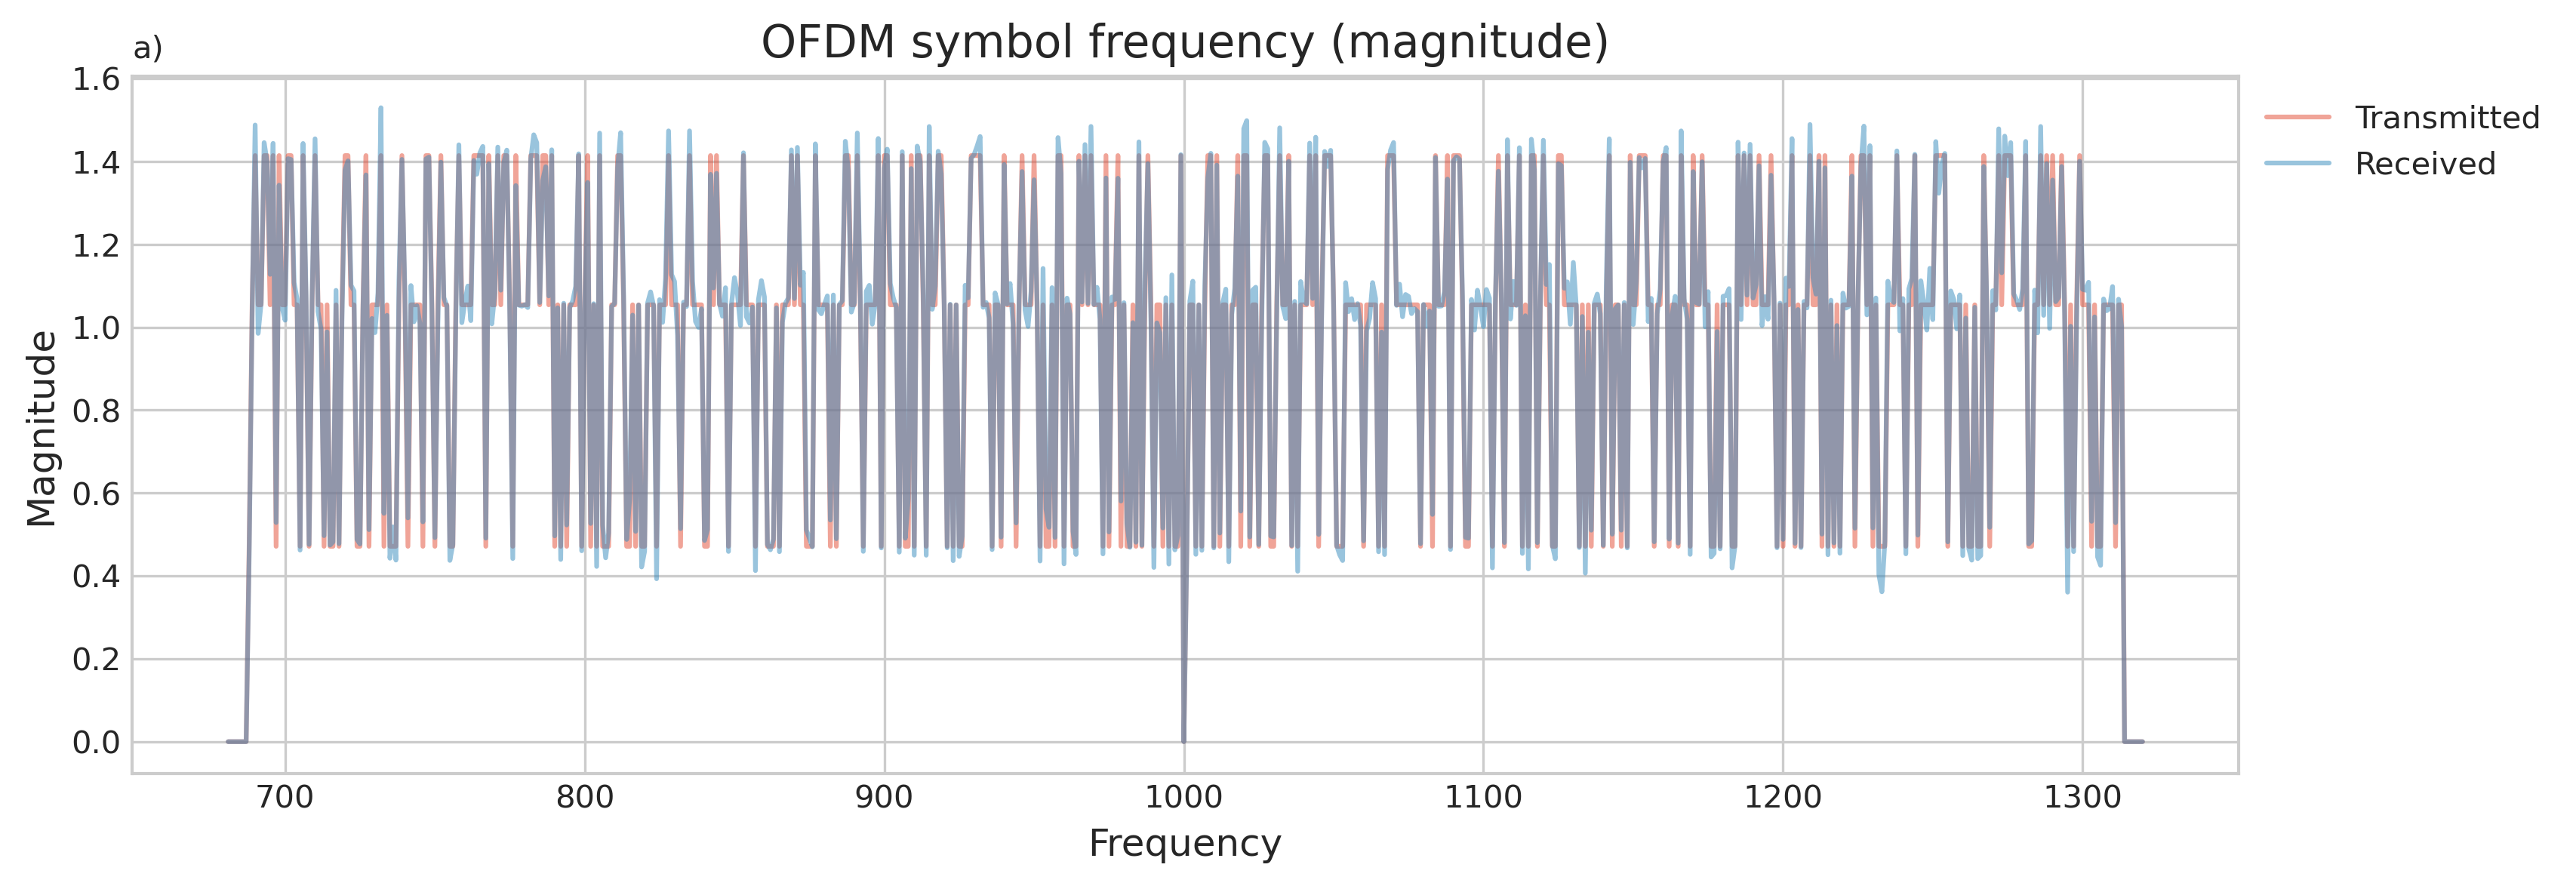

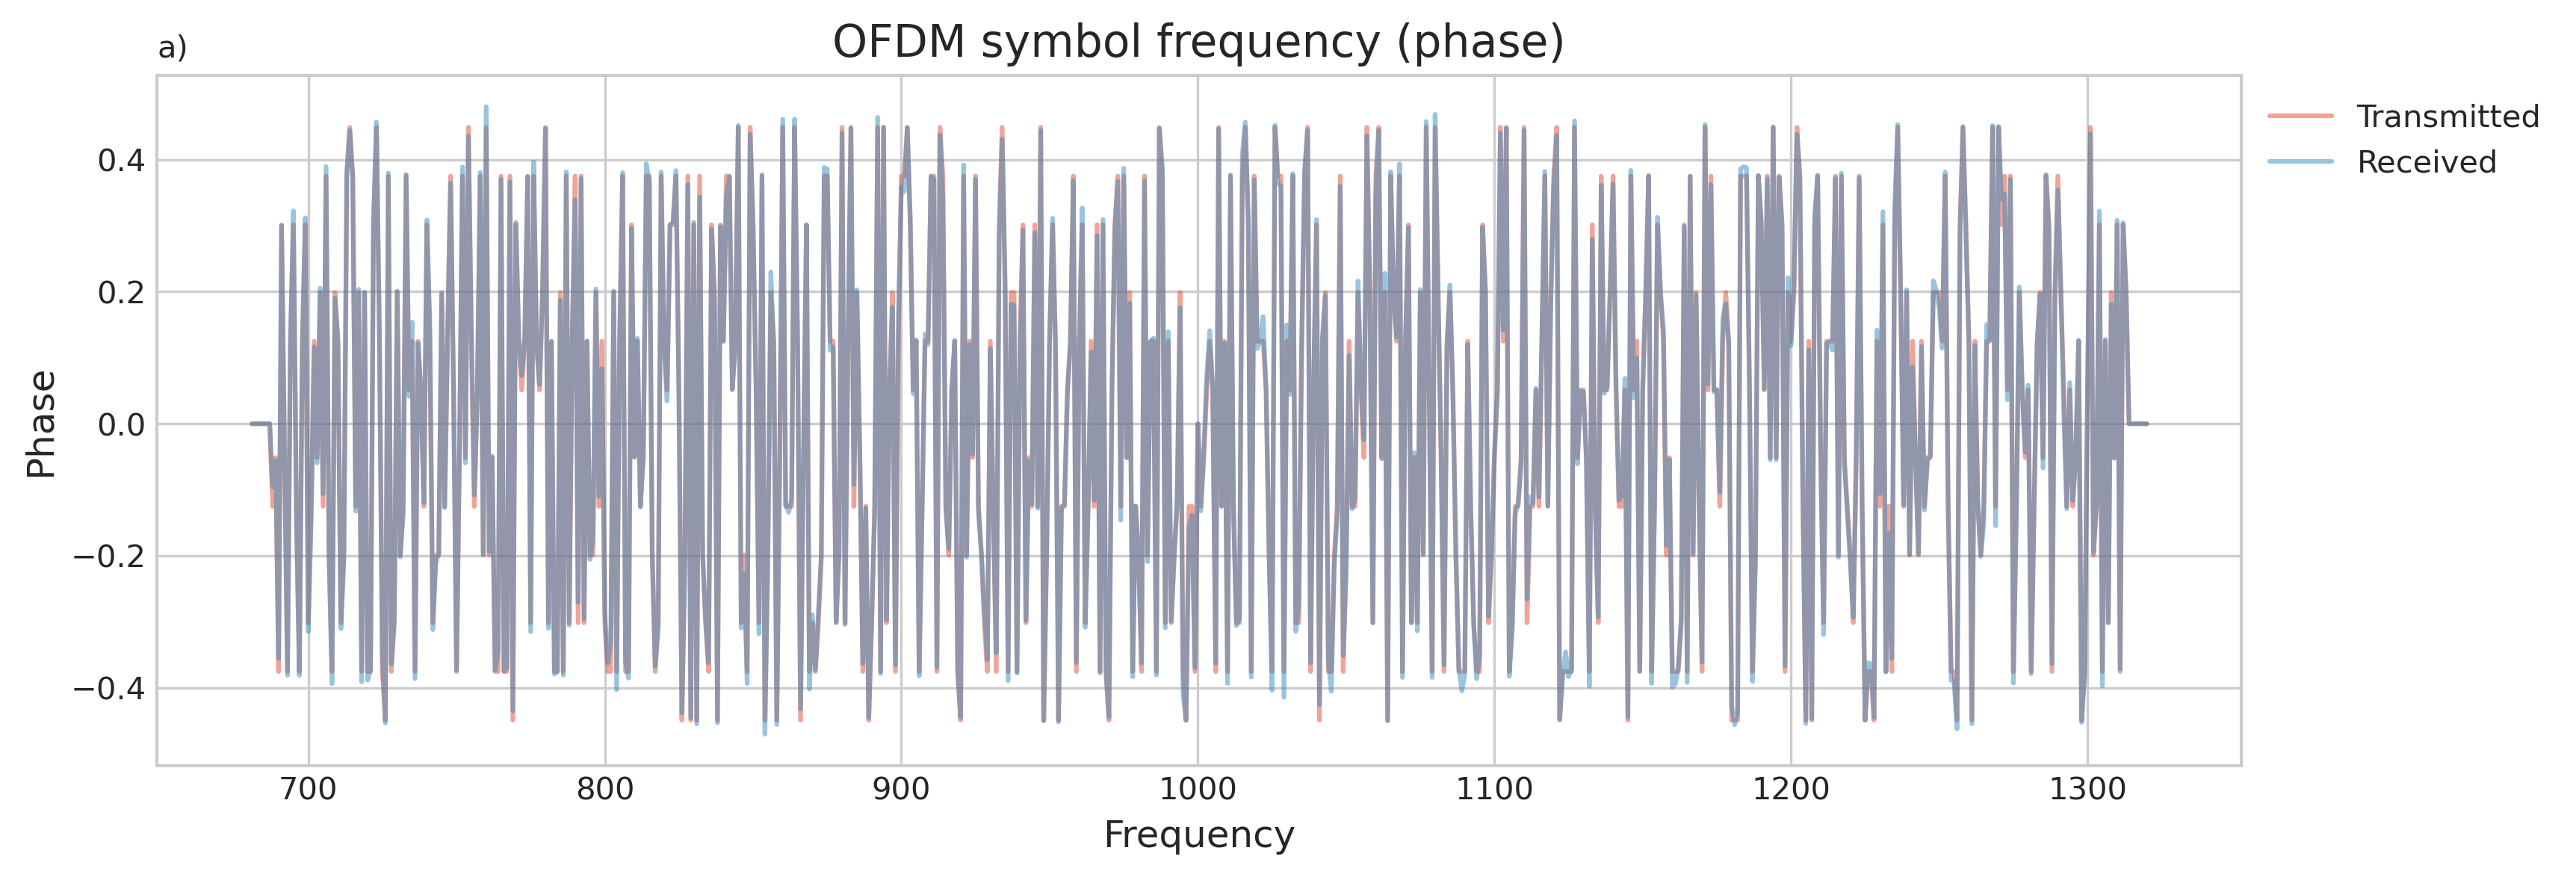

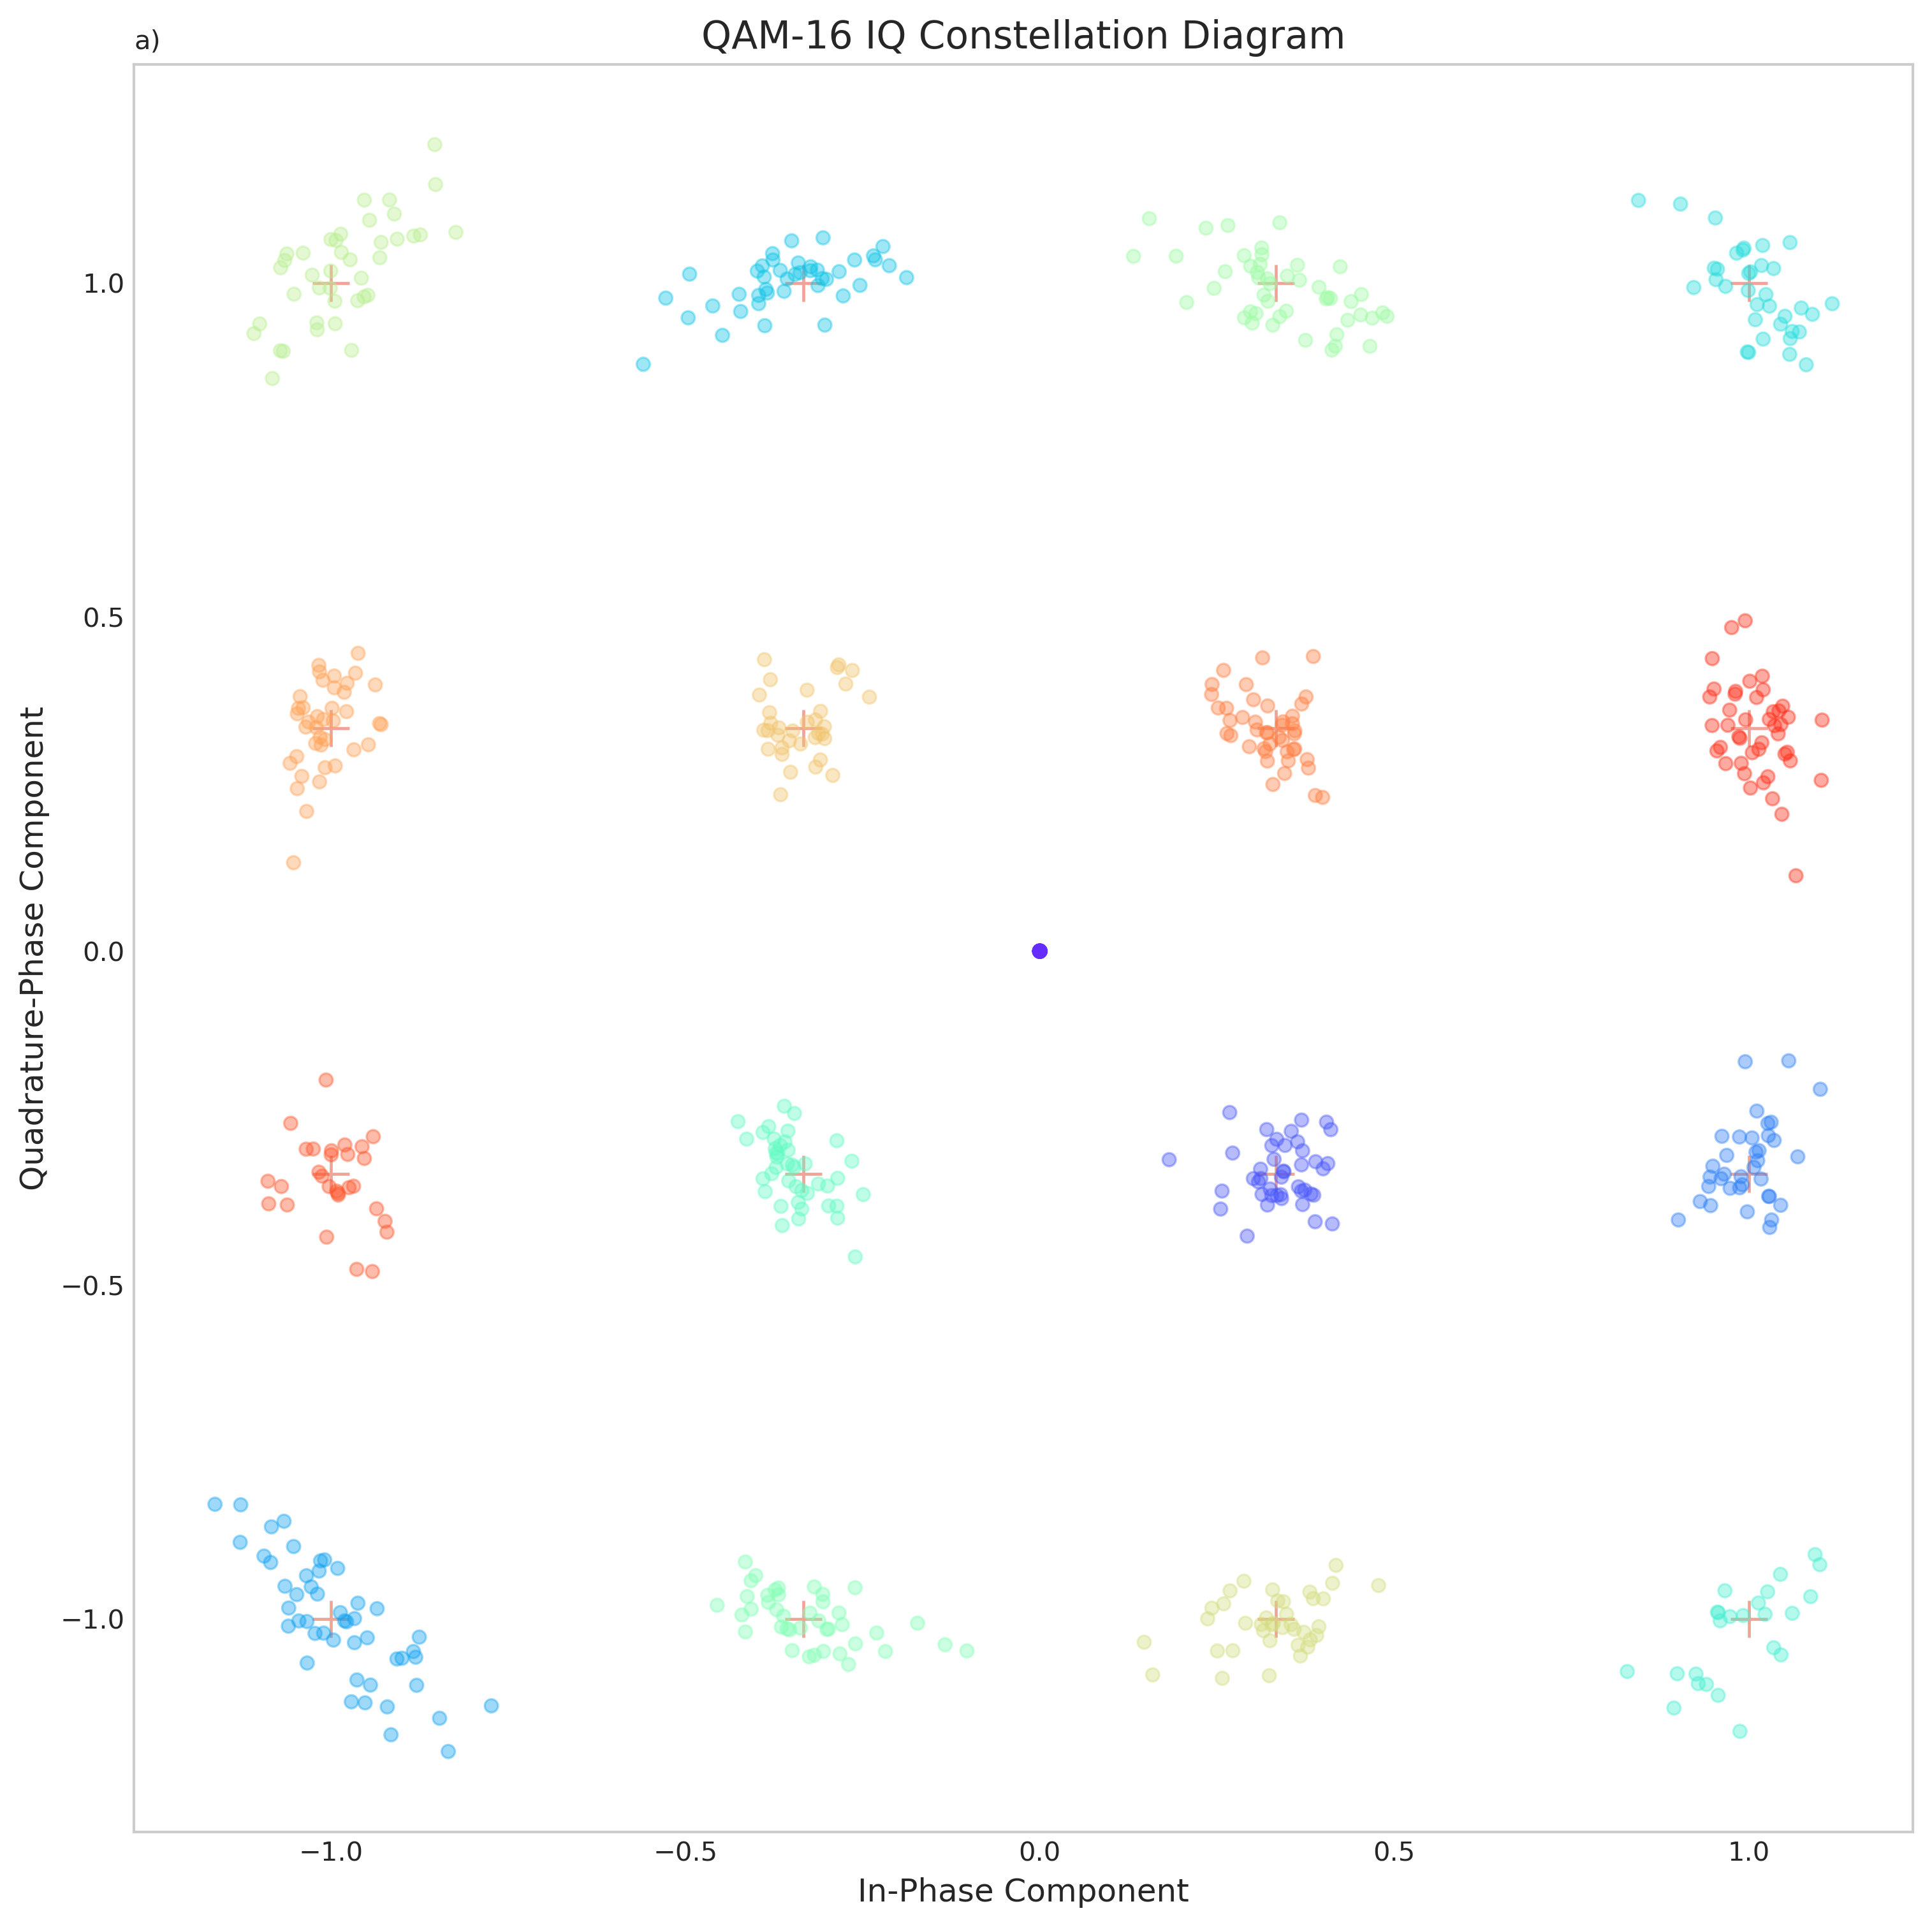

In [80]:
# %%
# OFDM modulation example
# WORKS!!!!

# Define OFDM parameters
# NOTE: Ensure that all subcarriers are a multiple of the symbol duration (so every frequency's period ends on the symbol's duration) to avoid FFT smearing.
# NOTE: Ensure the total number of samples (N) is at least twice the max frequency (Nyquist rate).
n_subs = 640  # Number of subcarriers
c_subs = 1000  # Centre of the channel frequency
s_subs = 1  # Subcarrier spacing in Hz
symbol_period = 1  # Symbol duration in seconds
sampling_freq = 5000  # Sampling frequency

# Possible QAM files (16-QAM)
n_qam = 2
vals = np.linspace(-1, 1, np.power(2, n_qam))
qam_vals = np.reshape(np.meshgrid(vals, vals), (2, -1))
qam_vals = qam_vals[0] + qam_vals[1] * 1j

(signal, t), (mod_vals, mod_freq), (demod_vals, demod_freq) = make_symbol(
    symbol_period, sampling_freq, c_subs, s_subs, n_subs, qam_vals
)

style = "seaborn-v0_8-whitegrid"
# Plot the real part of the OFDM symbol in the time domain
with plt.style.context(style):
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(
        t,
        signal,
        linewidth=0.3,
    )
    ax.set_title("a)", loc='left', fontsize='medium')
    ax.set_title("OFDM Symbol through time")
    ax.set_xlabel("Time")
    ax.set_ylabel("Amplitude")
    plt.show()

# Plot the OFDM signal in the frequency domain (Magnitude)
with plt.style.context(style):
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(
        mod_freq,
        np.abs(mod_vals),
        label="Transmitted",
        alpha=0.5,
    )
    ax.plot(
        demod_freq,
        np.abs(demod_vals),
        label="Received",
        alpha=0.5,
    )
    ax.set_title("a)", loc='left', fontsize='medium')
    ax.set_title("OFDM symbol frequency (magnitude)")
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Magnitude")
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Plot the OFDM signal in the frequency domain (Phase)
with plt.style.context(style):
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(
        mod_freq,
        np.angle(mod_vals) / (2 * np.pi),
        label="Transmitted",
        alpha=0.5,
    )
    ax.plot(
        demod_freq,
        np.angle(demod_vals) / (2 * np.pi),
        label="Received",
        alpha=0.5,
    )
    ax.set_title("a)", loc='left', fontsize='medium')
    ax.set_title("OFDM symbol frequency (phase)")
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Phase")
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))


# Getting intended symbols of demodulated (to check error rate)
x = np.array([])
for i, v in enumerate(mod_vals):
    x = np.append(x, v)
    if i != len(mod_vals) - 1:
        x = np.append(x, np.zeros(int(s_subs / (sampling_freq / (sampling_freq * symbol_period)) - 1)))
# Plot the demodulated OFDM symbol constellation diagram
with plt.style.context(style):
    fig, ax = plt.subplots(figsize=(12, 12))
    sns.scatterplot(
        x=np.real(qam_vals),
        y=np.imag(qam_vals),
        marker="+",
        s=200,
        alpha=0.5,
        edgecolor=None,
        ax=ax,
    )
    sns.scatterplot(
        x=np.real(demod_vals),
        y=np.imag(demod_vals),
        hue=x.astype(str),
        marker=".",
        palette="rainbow",
        alpha=0.4,
        edgecolor=None,
        s=100,
        ax=ax,
    )
    ax.set_title("a)", loc='left', fontsize='medium')
    ax.set_title("QAM-16 IQ Constellation Diagram")
    ax.set_xlabel("In-Phase Component")
    ax.set_ylabel("Quadrature-Phase Component")
    ax.grid(False)
    ax.get_legend().remove()


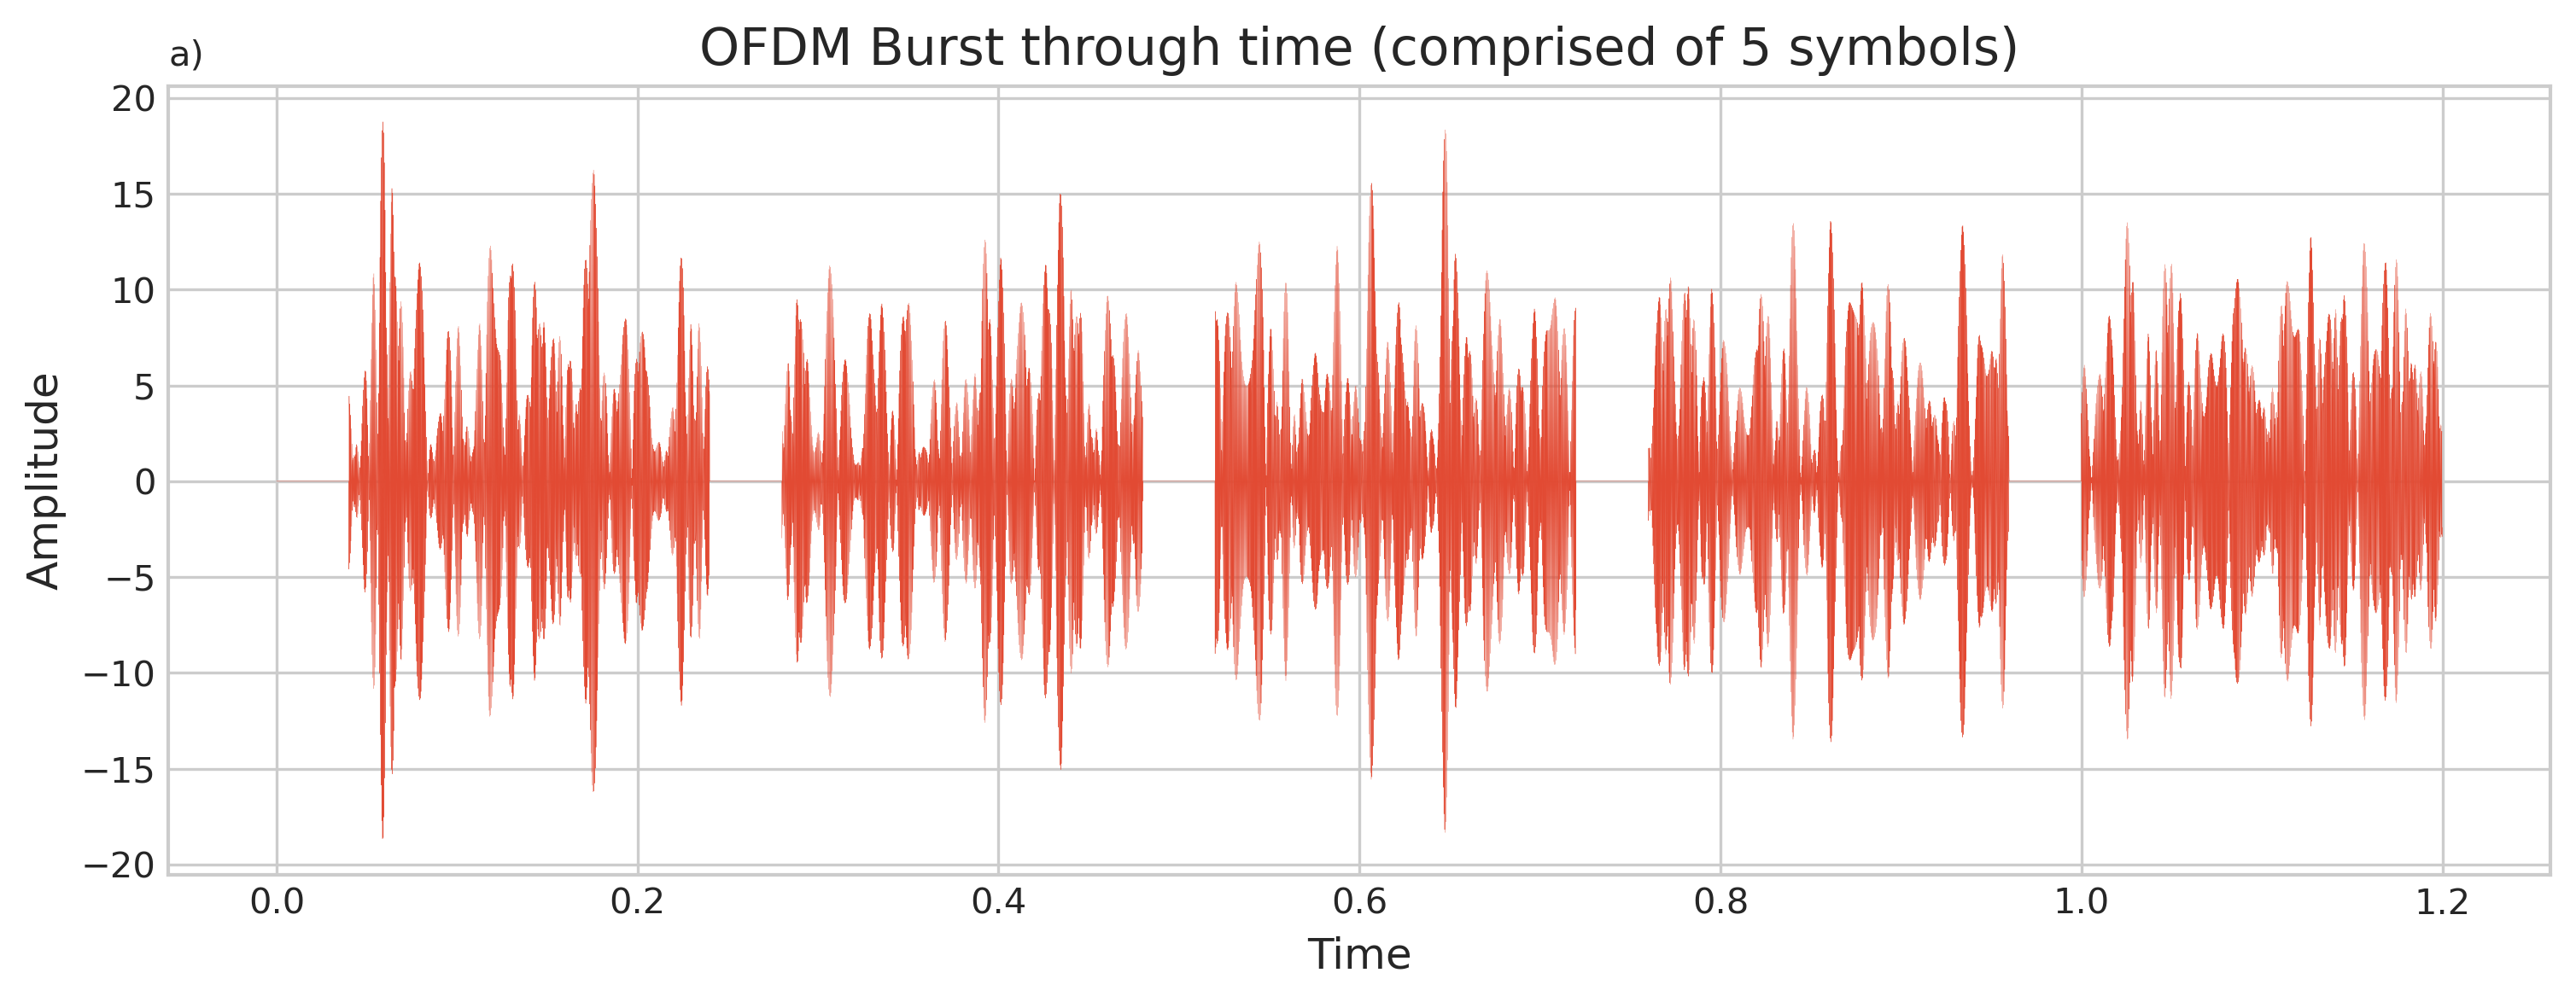

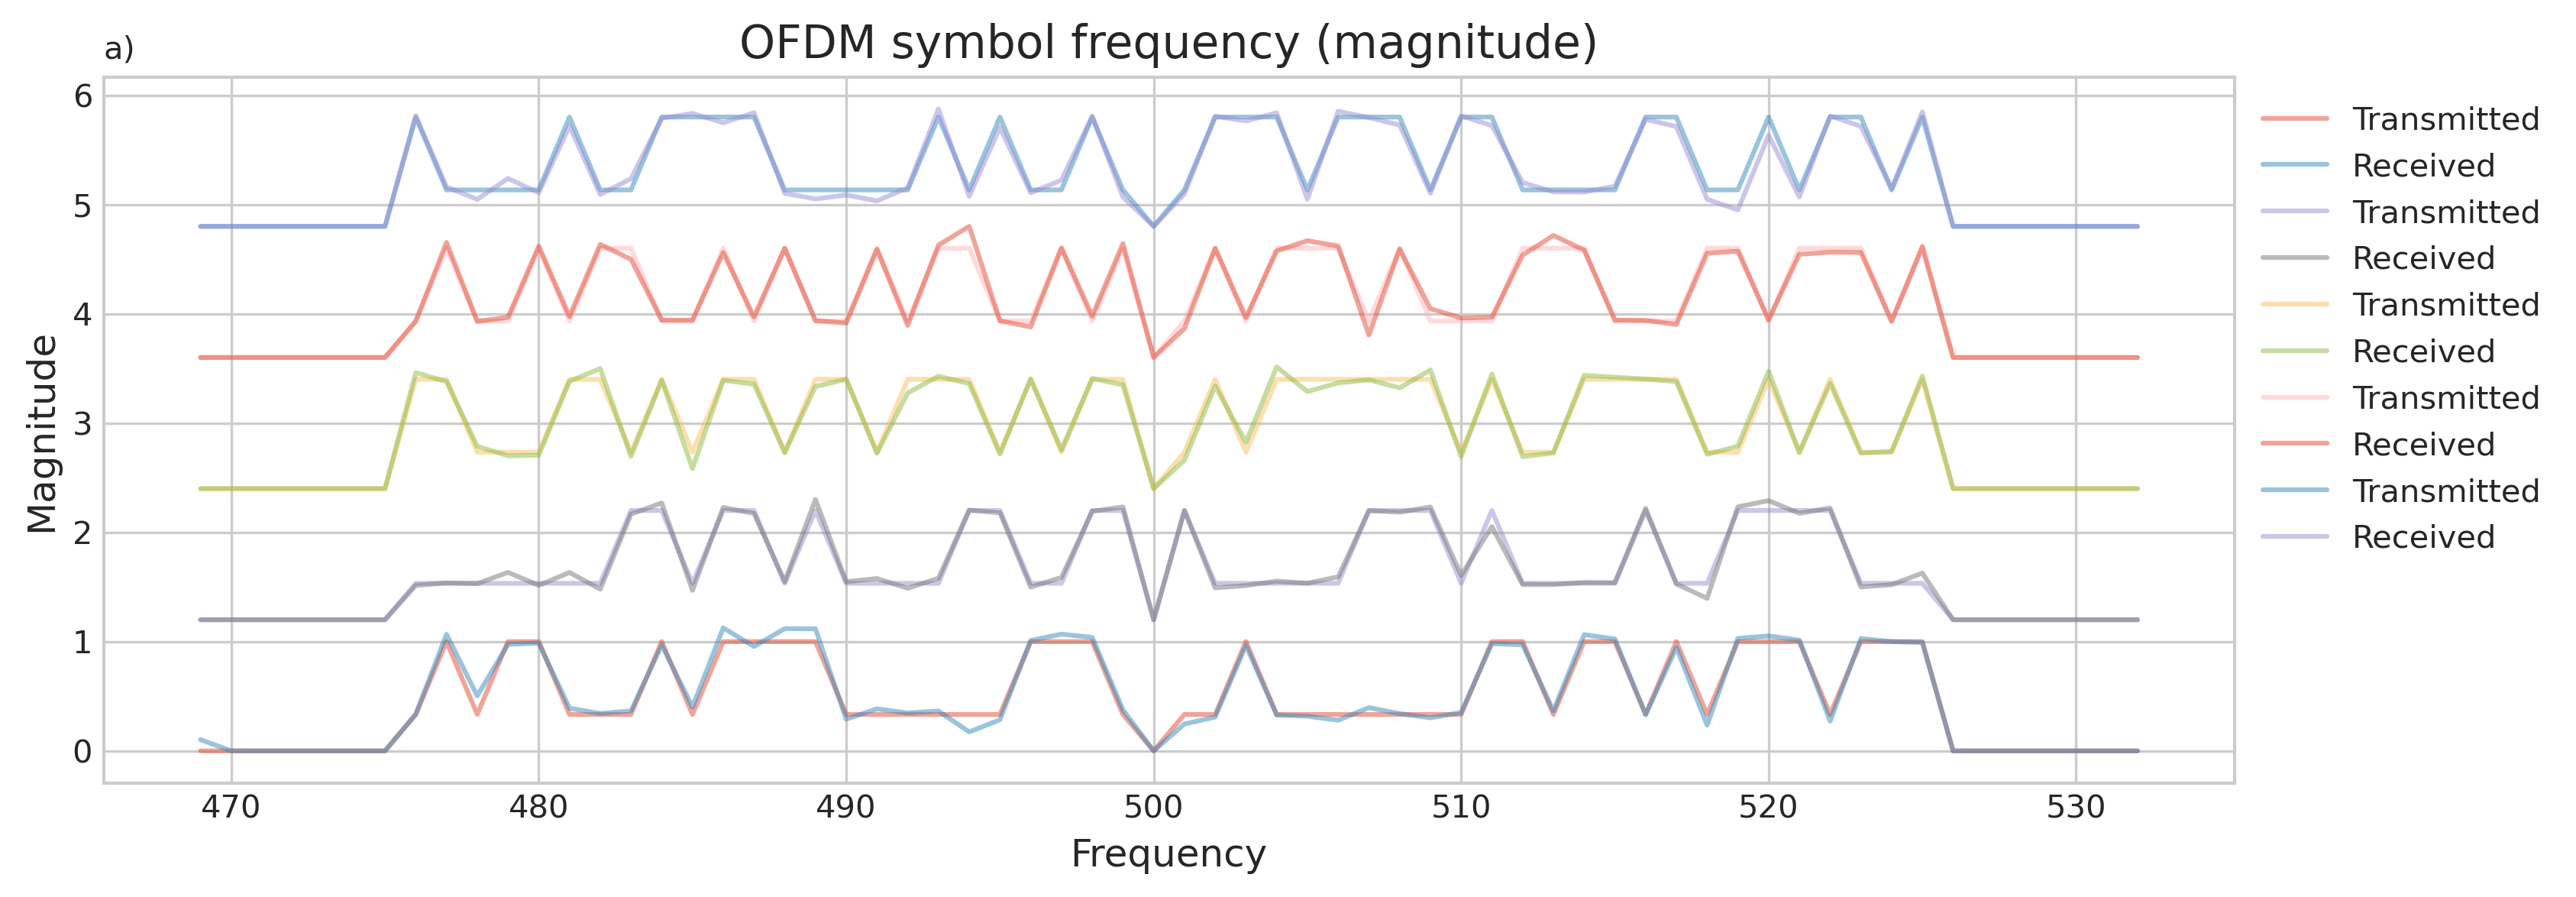

In [108]:

# %%

# OFDM burst of symbols example


# Define OFDM parameters
# NOTE: Ensure that all subcarriers are a multiple of the symbol duration (so every frequency's period ends on the symbol's duration) to avoid FFT smearing.
# NOTE: Ensure the total number of samples (N) is at least twice the max frequency (Nyquist rate).
n_subs = 64  # Number of subcarriers
c_subs = 500  # Centre of the channel frequency
s_subs = 1  # Subcarrier spacing in Hz
symbol_period = 1  # Symbol duration in seconds
sampling_freq = 2000  # Sampling frequency
n_symbols = 5
symbol_spacing = 0.2

# Possible QAM files (16-QAM)
n_qam = 2
vals = np.linspace(-1, 1, np.power(2, n_qam))
qam_vals = np.reshape(np.meshgrid(vals, vals), (2, -1))
qam_vals = qam_vals[0] + qam_vals[1] * 1j

spacing_signal = np.zeros(int(symbol_spacing*sampling_freq))
spacing_t = np.arange(0, symbol_spacing, 1/sampling_freq)

burst_signal = np.zeros((0,))
burst_t = np.arange(0, (symbol_period+symbol_spacing), 1/(n_symbols*sampling_freq))
burst_mod_vals = np.zeros((n_symbols, s_subs*n_subs))
burst_demod_vals = np.zeros((n_symbols, s_subs*n_subs))
freqs = np.linspace(
    c_subs - s_subs * n_subs / 2 + s_subs,
    c_subs + s_subs * n_subs / 2,
    n_subs,
)
for i in np.arange(n_symbols):
    (signal, t), (mod_vals, mod_freq), (demod_vals, demod_freq) = make_symbol(
        symbol_period, sampling_freq, c_subs, s_subs, n_subs, qam_vals
    )
    burst_signal = np.concatenate([burst_signal, spacing_signal, signal])
    burst_mod_vals[i] = mod_vals
    burst_demod_vals[i] = demod_vals


style = "seaborn-v0_8-whitegrid"
# Plot the real part of the OFDM symbol in the time domain
with plt.style.context(style):
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(
        burst_t,
        burst_signal,
        linewidth=0.1,
    )
    ax.set_title("a)", loc='left', fontsize='medium')
    ax.set_title("OFDM Burst through time (comprised of 5 symbols)")
    ax.set_xlabel("Time")
    ax.set_ylabel("Amplitude")

# Plot the OFDM signal in the frequency domain (Magnitude)
with plt.style.context(style):
    fig, ax = plt.subplots(figsize=(12, 4))
    for i, _ in enumerate(burst_mod_vals):
        ax.plot(
            freqs,
            np.abs(burst_mod_vals[i])+i*1.2,
            label="Transmitted",
            alpha=0.5,
        )
        ax.plot(
            freqs,
            np.abs(burst_demod_vals[i])+i*1.2,
            label="Received",
            alpha=0.5,
        )
    ax.set_title("a)", loc='left', fontsize='medium')
    ax.set_title("OFDM symbol frequency (magnitude)")
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Magnitude")
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
